# Assignment 10.

### Team members:

Zakhar Yagudin, Skoltech, 2023 <br>
CRediT author statement: Software

Khasan Akhmadiev, Skoltech, 2023 <br>
CRediT author statement: Software, Writing - review & editing

Konstantin Zamansky, Skoltech, 2023 <br>
CRediT author statement: Visualization, Writing - original draft

https://beta.elsevier.com/researcher/author/policies-and-guidelines/credit-author-statement?trial=true

*The objective of this laboratory work is to develop a tracking filter to estimate a vehicle’s
dynamic state by assimilating the navigation data coming from different sources. The task
includes the fusion of GPS data (absolute positioning) and wheel odometry data (relative
positioning). Important outcome of this exercise is getting skill to solve the most fundamental
data fusion tasks for intelligent traffic applications.*

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import polar
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

pd.options.plotting.backend = 'plotly'
pio.templates["standard"] = go.layout.Template(layout=dict(
    title_font_family = 'Courier',
    font_size = 20,
    margin = dict(t=50, b=0, l=50, r=0),
    yaxis_nticks = 4,
    xaxis_nticks = 5,
    legend_title = '',
    legend_font_family = 'Courier',
    legend_orientation = 'v',
    legend_xanchor = 'right',
    legend_bgcolor = 'rgba(256,256,256,0.8)',
    legend_x = 1,
    legend_y = 1.15,
    width = 1150, 
    height = 500)
)
colors = px.colors.qualitative.Plotly
pio.templates.default = 'simple_white+standard'

T = 0.05
V_module = 10
F = np.kron(np.eye(2), np.array([[1, T], [0, 1]]))
G = np.kron(np.eye(2), np.array([T**2/2, T])).T

sample_size = 500
sigma_a = 1
sigmaA = 5
sigma_nu = 3
sigma_V = 0.5
sigma_theta = 0.02


### #1 Download the file

In [2]:
theta = pd.read_csv('theta.txt', header = None, decimal = '.', names = ['theta'])
theta = theta.to_numpy().ravel()

## Part I

### #2 Generate true trajectory

In [3]:
def state_equation(theta, T, G, sigma_a, sample_size: int = 500, 
                   X0: float = 0, 
                   V_module: float = 10, 
                   Y0: float = 0,):

    # Initial conditions to generate trajectory
    X_vector_c = np.zeros((4, sample_size))
    V0_x, V0_y = V_module, V_module
    X_vector_c[:, 0] = np.array([X0, V0_x, Y0, V0_y])

    for i in range(1, sample_size):
    
        F = np.array([[1, T*np.cos(theta[i-1]), 0, 0],
                      [0, np.cos(theta[i-1]), 0, 0],
                      [0, 0, 1, T*np.sin(theta[i-1])],
                      [0, 0, 0, np.sin(theta[i-1])]])
        
        # calculate State equation
        X_vector_c[:, i] = F @ X_vector_c[:, i-1] + G @ np.random.normal(scale=sigma_a, size=2)

    return X_vector_c

### #3 Generate measurements

In [4]:
def measurements(X, theta, sample_size = 500, sigma_nu: float = 3, sigma_V: float = 0.5, sigma_theta: float = 0.02):
    
    Z = np.zeros((4, sample_size))
    zx = X[0, :] + np.random.normal(scale = sigma_nu, size = sample_size)
    zy = X[2, :] + np.random.normal(scale= sigma_nu, size = sample_size)
    zV = np.sqrt(X[1, :]**2 + X[3, :]**2) + np.random.normal(scale= sigma_V, size = sample_size)
    z_theta = theta + np.random.normal(scale=sigma_theta, size=sample_size)
    Z[0, :] += zx
    Z[1, :] += zy
    Z[2, :] += zV
    Z[3, :] += z_theta
    return Z

### #4 Linear Kalman Filter

In [5]:
def LKF(sample_size, X_vector, GPS_vector, theta, T, G, sigmaA, sigma_nu, sigma_V, sigma_theta, P0_0_diag, EKF: bool = False):
    # Covariance matrix of state noise
    Q = G @ G.T * sigmaA**2

    # Initial zeros values for Cartesian coordinates
    X_filtered = np.zeros((4, sample_size))
    X_extrapol = np.zeros((4, sample_size))

    # Initial filtered estimates
    X_filtered[:, 0] = np.array([GPS_vector[0, 1],
                                (GPS_vector[0, 1] - GPS_vector[0, 0])/T,
                                GPS_vector[1, 1],
                                (GPS_vector[1, 1] - GPS_vector[1, 0])/T])
    X_extrapol[:, 0] = X_filtered[:, 0]

    # Initial filtration error covariance matrix
    P0 = np.eye(X_filtered.shape[0]) * P0_0_diag
    
    if not EKF:
        # Linear Kalman Filter
        R = np.eye(2) * sigma_nu
        H = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

        for i in range(1, sample_size):
            F = np.array([[1, T*np.cos(theta[i-1]), 0, 0],
                        [0, np.cos(theta[i-1]), 0, 0],
                        [0, 0, 1, T*np.sin(theta[i-1])],
                        [0, 0, 0, np.sin(theta[i-1])]])
                    
            X_pred = F @ X_filtered[:, i-1]
            X_extrapol[:, i] = X_pred
            P_pred = F @ P0 @ F.T + Q
            K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
            X_filtered[:, i] = X_pred + K @ (GPS_vector[:2, i] - H @ X_pred)
            P0 = P_pred - K @ H @ P_pred
    
    else:
        # Extended Kalman Filter
        R = np.eye(4) * np.array([sigma_nu, sigma_nu, sigma_V, sigma_theta])

        for i in range(1, sample_size-1):    
            F = np.array([[1, T*np.cos(theta[i-1]), 0, 0],
                        [0, np.cos(theta[i-1]), 0, 0],
                        [0, 0, 1, T*np.sin(theta[i-1])],
                        [0, 0, 0, np.sin(theta[i-1])]])
                    
            X_pred = F @ X_filtered[:, i-1]
            X_extrapol[:, i] = X_pred
            # Observation function
            h = np.array([X_extrapol[0, i], 
                        X_extrapol[2, i], 
                        np.sqrt(X_extrapol[1, i]**2 + X_extrapol[3, i]**2),
                        np.arctan2(X_extrapol[3, i], X_extrapol[1, i])])

            Vm = X_extrapol[1, i-1]**2 + X_extrapol[3, i-1]**2
            dh = np.array([[1, 0, 0, 0],
                        [0, 0, 1, 0],
                        [0, X_extrapol[1, i-1]/np.sqrt(Vm), 0, X_extrapol[3, i-1]/np.sqrt(Vm)],
                        [0, -X_extrapol[3, i-1]/Vm, 0, X_extrapol[1, i-1]/Vm]])

            P_pred = F @ P0 @ F.T + Q
            K = P_pred @ dh.T @ np.linalg.inv(dh @ P_pred @ dh.T + R)
            X_filtered[:, i] = X_pred + K @ (GPS_vector[:, i+1] - h)
            P0 = P_pred - K @ dh @ P_pred    

    return X_filtered, X_extrapol


### Plot of True trajectory, measurements and filtered estimates

In [6]:
X_vector = state_equation(theta=theta, T=T, G=G, sigma_a=sigma_a,
                            sample_size=sample_size, 
                            X0=0, Y0=0, V_module=V_module)

GPS_vector = measurements(X=X_vector, theta=theta, 
                          sample_size=sample_size, sigma_nu=sigma_nu, sigma_theta=sigma_theta)

X_filtered, X_extrapol = LKF(sample_size=sample_size, X_vector=X_vector, 
                             GPS_vector=GPS_vector, theta=theta, T=T, G=G, sigmaA=5, 
                             sigma_nu=sigma_nu, sigma_V=sigma_V, sigma_theta=sigma_theta, P0_0_diag=10**4, EKF=False)

In [7]:
fig = go.Figure()
colors = px.colors.qualitative.Plotly
fig.add_trace(go.Scatter(x = np.arange(sample_size), y = X_vector[0, :], line_color = colors[1], name="True Trajectory"))
fig.add_trace(go.Scatter(x = np.arange(sample_size), y = X_filtered[0, :], line_color = colors[5], name="Filtered Trajectory"))
fig.add_trace(go.Scatter(x = np.arange(sample_size), y = GPS_vector[0, :], line_color = colors[0], mode="markers", name="Measurments"))

fig.update_layout(title='Motion', xaxis_title='<b>step #</b>',yaxis_title = "<b>X, m</b>")
fig.show()

fig.write_image("Motion.png", format = 'png', width = 1150, height = 500, scale = 2)

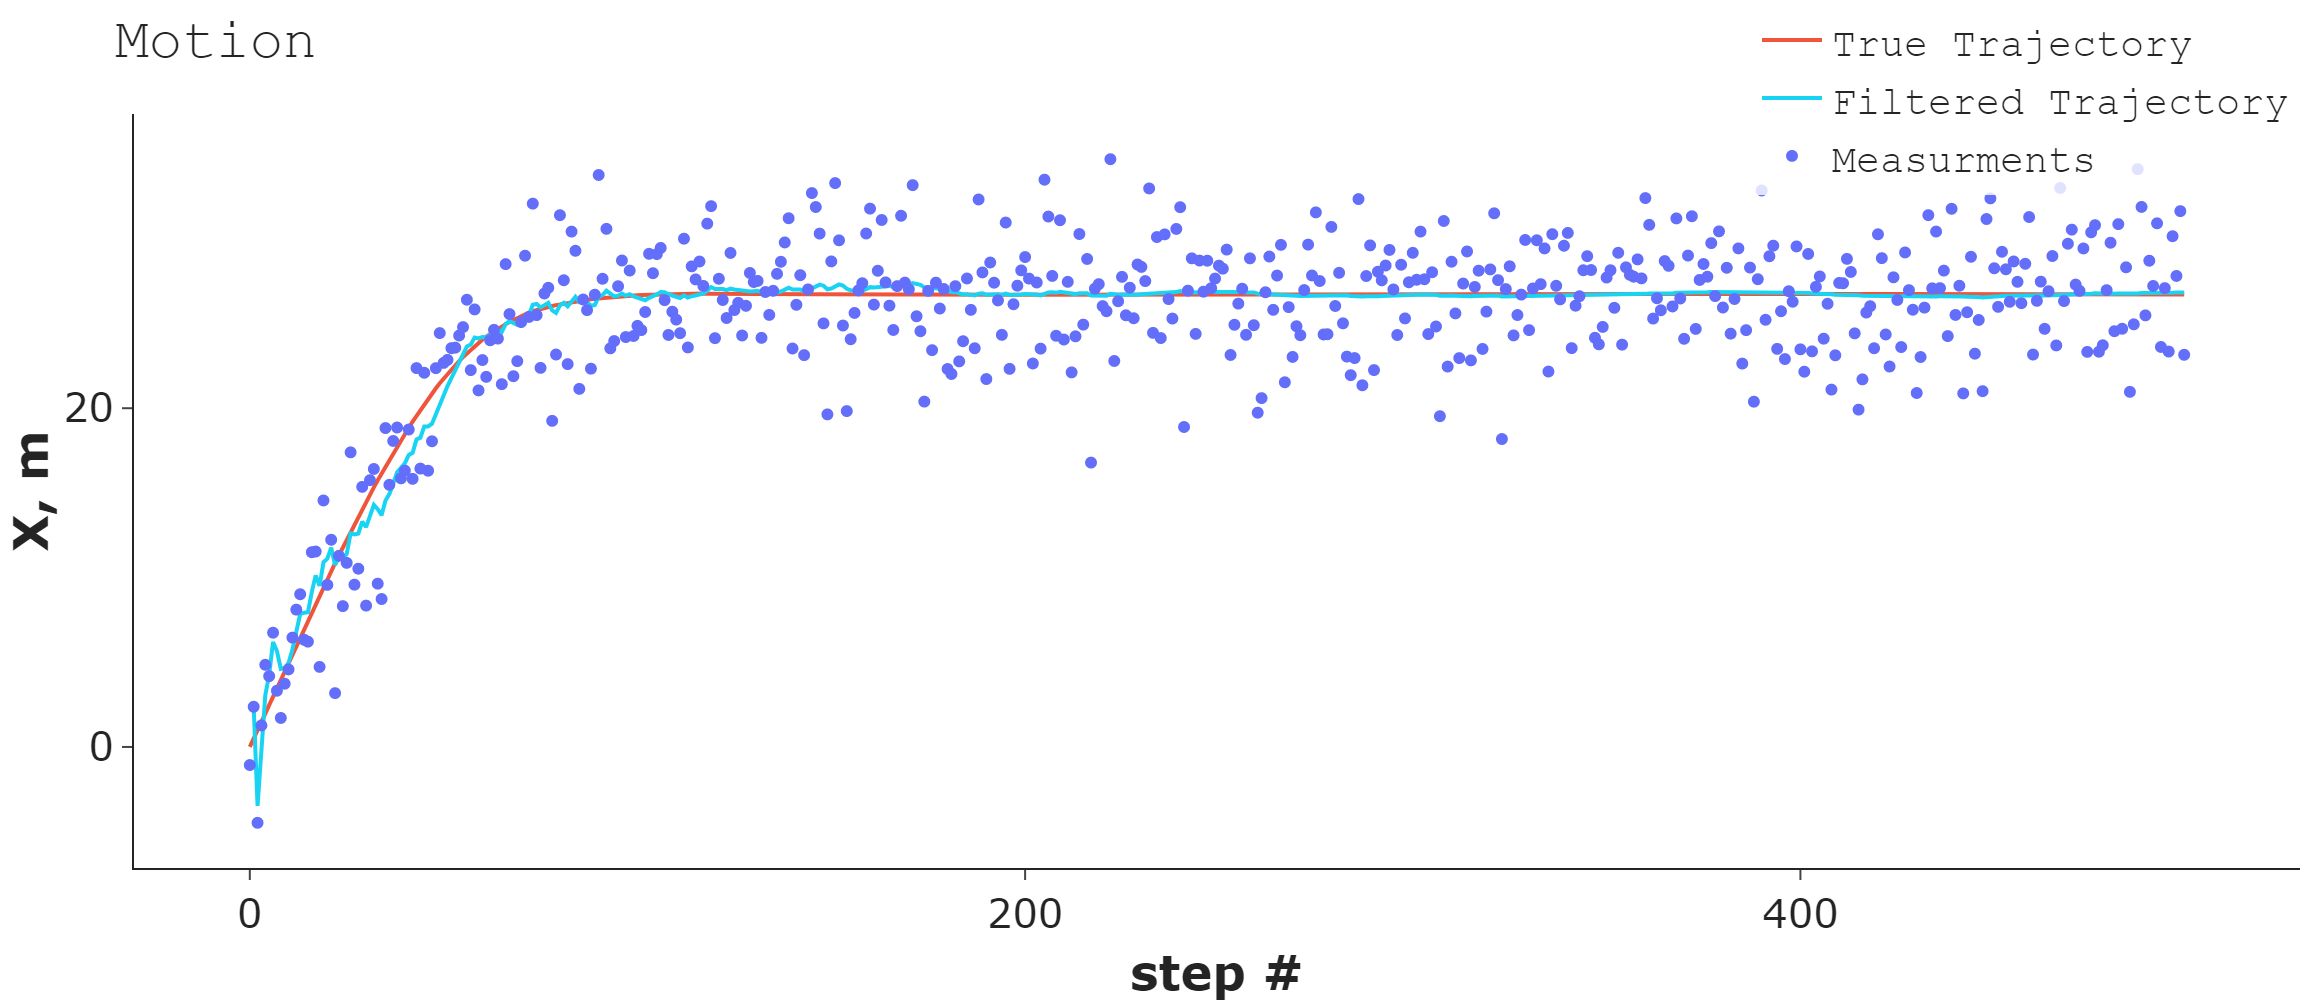

In [8]:
Image("Motion.png")

### #5 True estimation errors of extrapolation and filtration estimates

In [9]:
def final_error(sample_size: int = 500, M: int = 500, 
                X0: float = 0, V_module: float = 10, Y0: float = 0, P0_0_diag: float = 10**4, EKF: bool = False):
    
    #Initialization of matrices
    Error_true_filtered = np.zeros((4, sample_size))
    Error_true_extrapol = np.zeros((4, sample_size))

    for i in range(M):
        # State vector
        X_vector = state_equation(theta=theta, T=T, G=G, sigma_a=sigma_a,
                                  sample_size=sample_size, 
                                  X0=0, Y0=0, V_module=V_module)
        # Measurements
        GPS_vector = measurements(X=X_vector, theta=theta, 
                                sample_size=sample_size, 
                                sigma_nu=sigma_nu, 
                                sigma_theta=sigma_theta)
        
        # Kalman filter
        X_filtered, X_extrapol = LKF(sample_size=sample_size, 
                                        X_vector=X_vector,
                                        GPS_vector=GPS_vector, theta=theta, T=T, G=G, sigmaA=5, 
                                        sigma_nu=sigma_nu, sigma_V=sigma_V, 
                                        sigma_theta=sigma_theta, P0_0_diag=P0_0_diag, EKF=EKF)

        # Error calculation
        Error_true_filtered += (X_vector - X_filtered) ** 2
        Error_true_extrapol += (X_vector - X_extrapol) ** 2

    #Final error calculation over M runs
    RMSE_true_filtered = np.sqrt(Error_true_filtered / (M - 1))
    RMSE_true_extrapol = np.sqrt(Error_true_extrapol / (M - 1))

    return RMSE_true_filtered, RMSE_true_extrapol

In [10]:
RMSE_true_filtered, RMSE_true_extrapol = final_error(sample_size=500, M=500, X0=0, V_module=V_module, Y0=0, P0_0_diag=10**4, EKF=False)

In [11]:
from plotly.subplots import make_subplots

fig = make_subplots(rows = 1, cols = 2, horizontal_spacing = 0.07, subplot_titles= ["<b>Coordinate X</b>", "<b>Coordinate Y</b>"])
x=np.arange(sample_size)

fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered[0, :], name = 'filtered', line_color = colors[0]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_extrapol[0, :], name = 'extrapolated', line_color = colors[2]), row = 1, col = 1)

fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered[2, :], name = 'filtered', line_color = colors[0], showlegend = False), row = 1, col = 2)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_extrapol[2, :], name = 'extrapolated', line_color = colors[2], showlegend = False), row = 1, col = 2)

fig.update_xaxes(mirror = True)
fig.update_yaxes(mirror = True)

fig.update_annotations(font_size = 30, font_family = "Courier")
fig.update_layout(title = "<b>RMSE</b>",
                  xaxis_title = "<b>step#</b>",
                  yaxis_title = "<b>\u03c3, m</b>",
                  xaxis2_title = "<b>step#</b>",
                  yaxis2_title = "<b>\u03c3, m</b>",
                  margin_t = 50,
                  legend_y = 1)

fig.show()

fig.write_image("RMSE.png", format = 'png', width = 1150, height = 500, scale = 2)

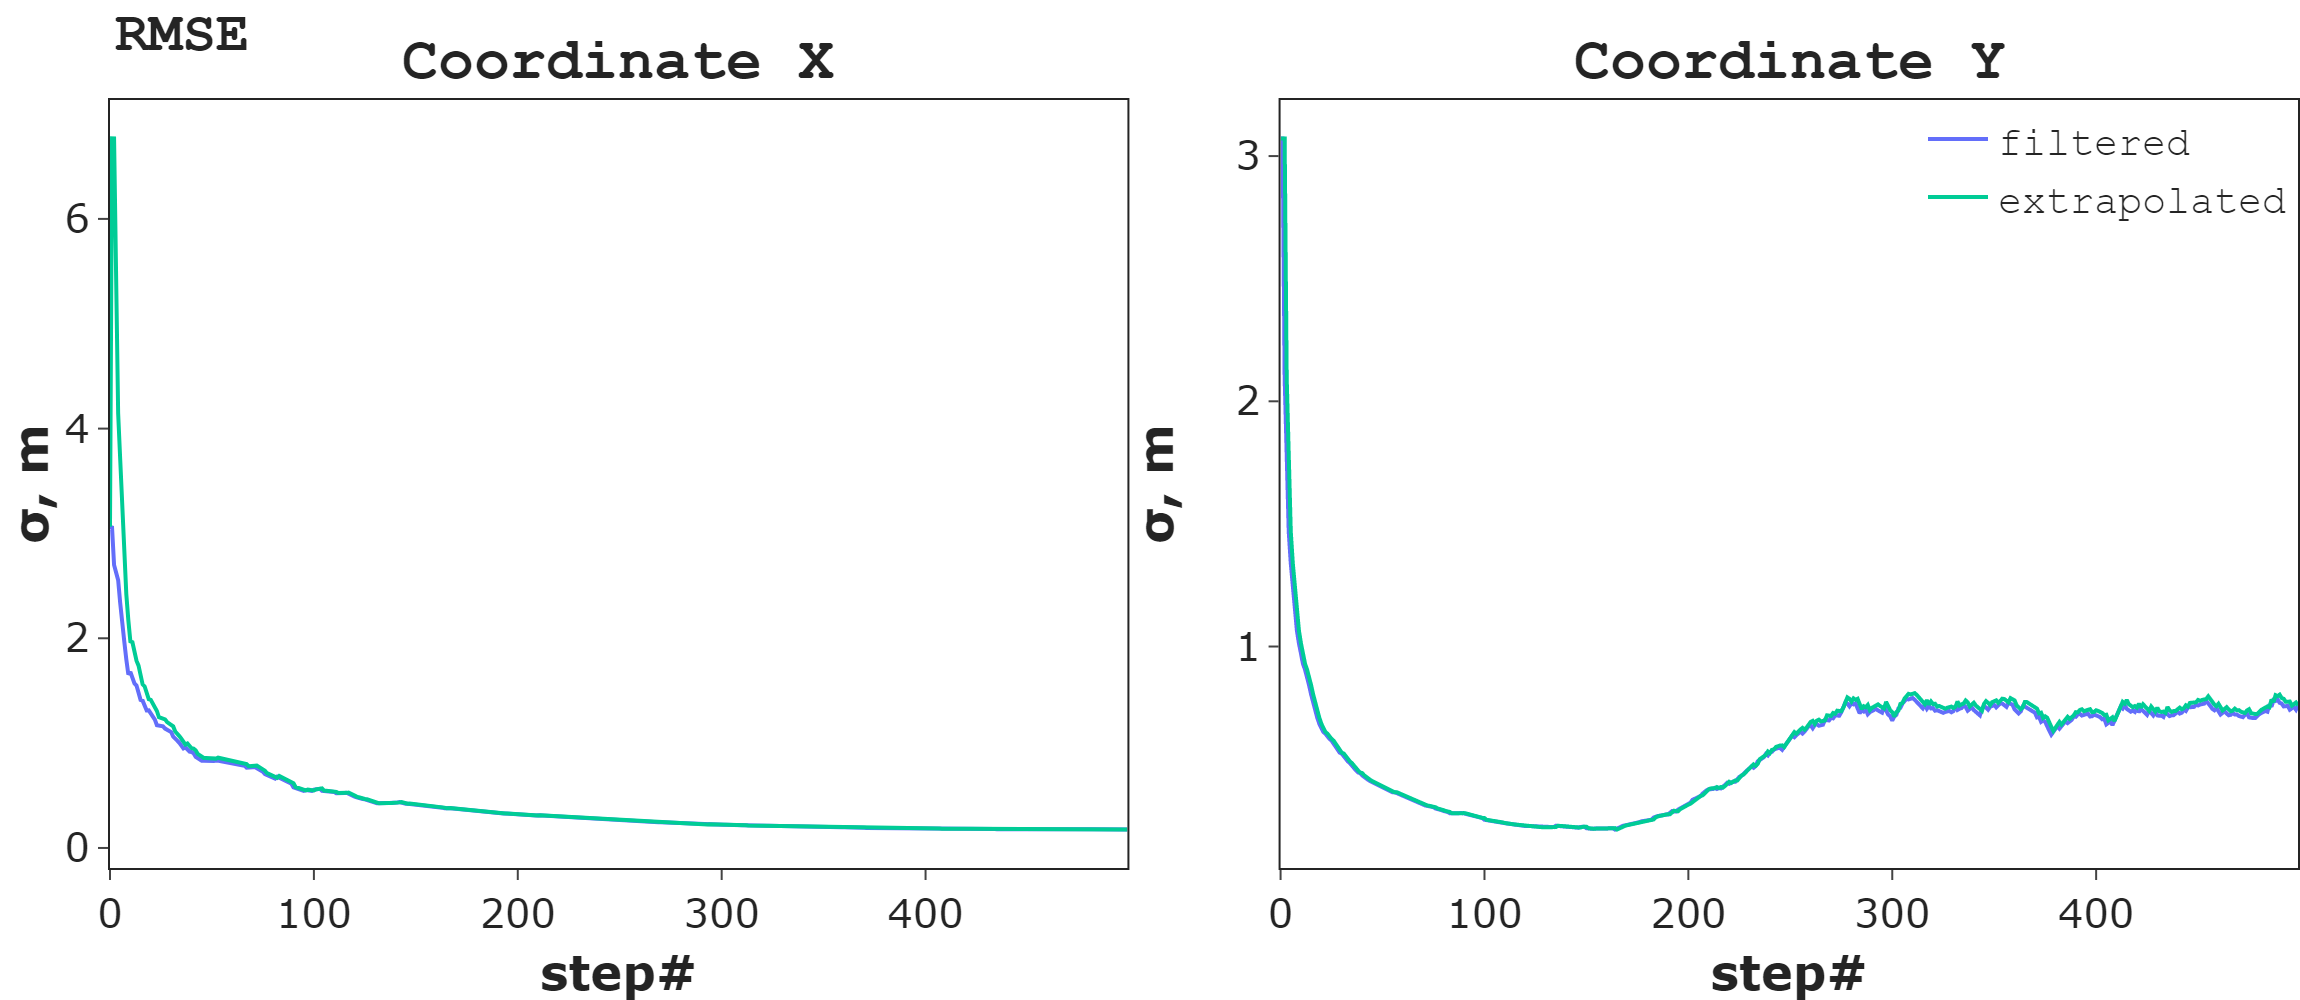

In [12]:
Image("RMSE.png")

## Second part

### Generate true trajectory, measurements (GPS data and wheel odometry data) and filtered estimates using EKF

In [13]:
X_vector_ext = state_equation(theta=theta, T=T, G=G, sigma_a=sigma_a,
                            sample_size=sample_size, 
                            X0=0, Y0=0, V_module=V_module)

GPS_vector_ext = measurements(X=X_vector_ext, theta=theta, 
                          sample_size=sample_size, sigma_nu=sigma_nu, sigma_theta=sigma_theta)

X_filtered_ext, X_extrapol_ext = LKF(sample_size=sample_size, 
                             X_vector=X_vector_ext, 
                             GPS_vector=GPS_vector_ext, theta=theta, T=T, G=G, sigmaA=5, 
                             sigma_nu=sigma_nu, sigma_V=sigma_V, sigma_theta=sigma_theta, P0_0_diag=10**4, EKF=True)

In [14]:
fig = go.Figure()
colors = px.colors.qualitative.Plotly
x = np.arange(sample_size)
fig.add_trace(go.Scatter(x = x, y = X_vector_ext[0, :sample_size-1], line_color = colors[1], name="True Trajectory"))
fig.add_trace(go.Scatter(x = x, y = GPS_vector_ext[0, :sample_size-1], line_color = colors[0], mode="markers", name="Measurments"))
fig.add_trace(go.Scatter(x = x, y = X_filtered_ext[0, :sample_size-1], line_color = colors[5], name="Filtered Trajectory"))

fig.update_layout(title='Motion', xaxis_title='<b>X, m</b>',yaxis_title = "<b>step #</b>")
fig.show()

fig.write_image("Motion_ext.png", format = 'png', width = 1150, height = 500, scale = 2)

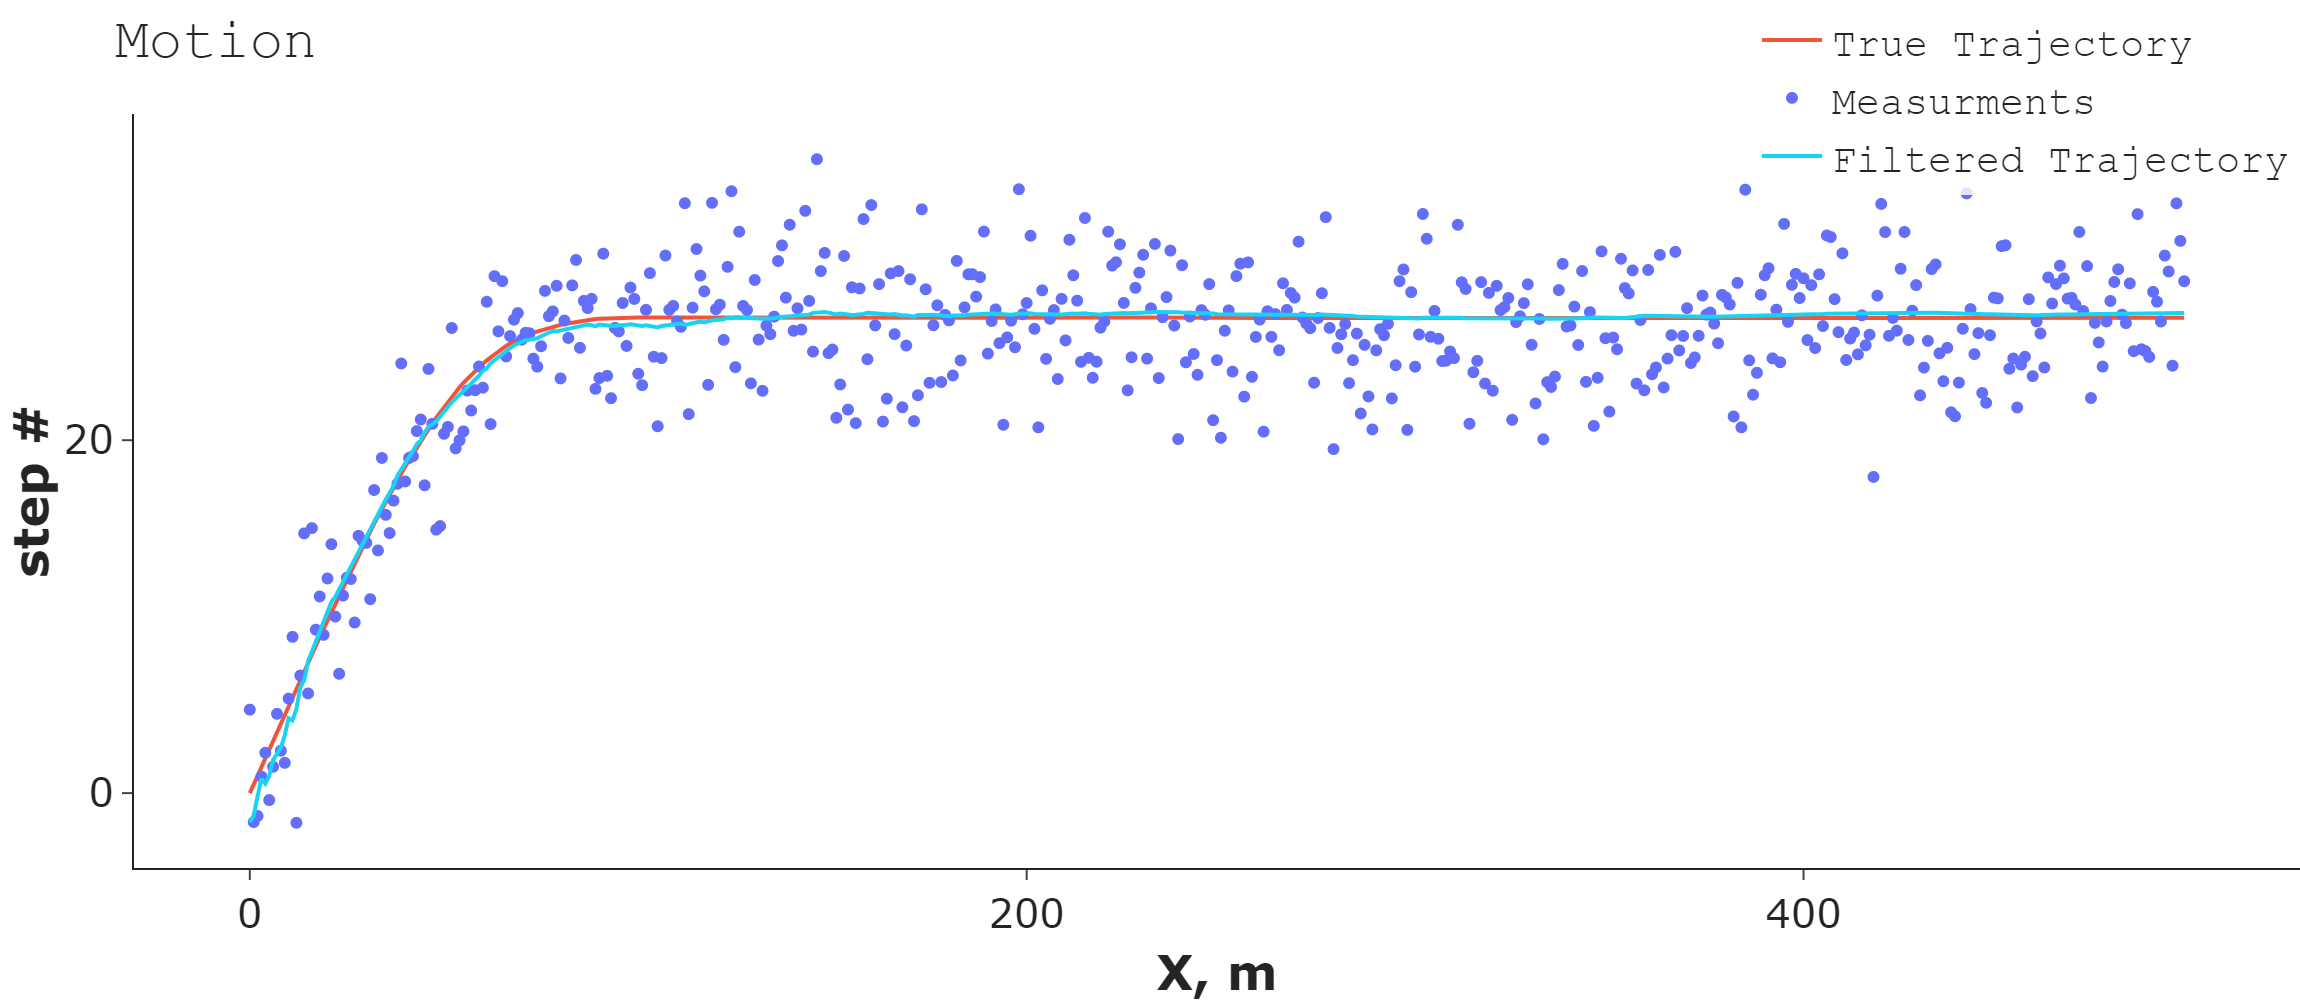

In [15]:
Image("Motion_ext.png")

### #6 True estimation errors of extrapolated and filtered estimates using EKF

In [16]:
RMSE_true_filtered_ext, RMSE_true_extrapol_ext = final_error(sample_size=500, M=500, X0=0, V_module=V_module, Y0=0, P0_0_diag=10**4, EKF=True)

In [17]:
from plotly.subplots import make_subplots

fig = make_subplots(rows = 1, cols = 2, horizontal_spacing = 0.07, subplot_titles= ["<b>Coordinate X</b>", "<b>Coordinate Y</b>"])
x=np.arange(sample_size)

fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered_ext[0, :sample_size-1], name = 'filtered', line_color = colors[0]), row = 1, col = 1)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_extrapol_ext[0, :sample_size-1], name = 'extrapolated', line_color = colors[2]), row = 1, col = 1)

fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered_ext[2, :sample_size-1], name = 'filtered', line_color = colors[0], showlegend = False), row = 1, col = 2)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_extrapol_ext[2, :sample_size-1], name = 'extrapolated', line_color = colors[2], showlegend = False), row = 1, col = 2)

fig.update_xaxes(mirror = True)
fig.update_yaxes(mirror = True)

fig.update_annotations(font_size = 30, font_family = "Courier")
fig.update_layout(title = "<b>RMSE</b>",
                  xaxis_title = "<b>step#</b>",
                  yaxis_title = "<b>\u03c3, m</b>",
                  xaxis2_title = "<b>step#</b>",
                  yaxis2_title = "<b>\u03c3, m</b>",
                  margin_t = 50,
                  legend_y = 1)

fig.show()
fig.write_image("RMSE_ext.png", format = 'png', width = 1150, height = 500, scale = 2)

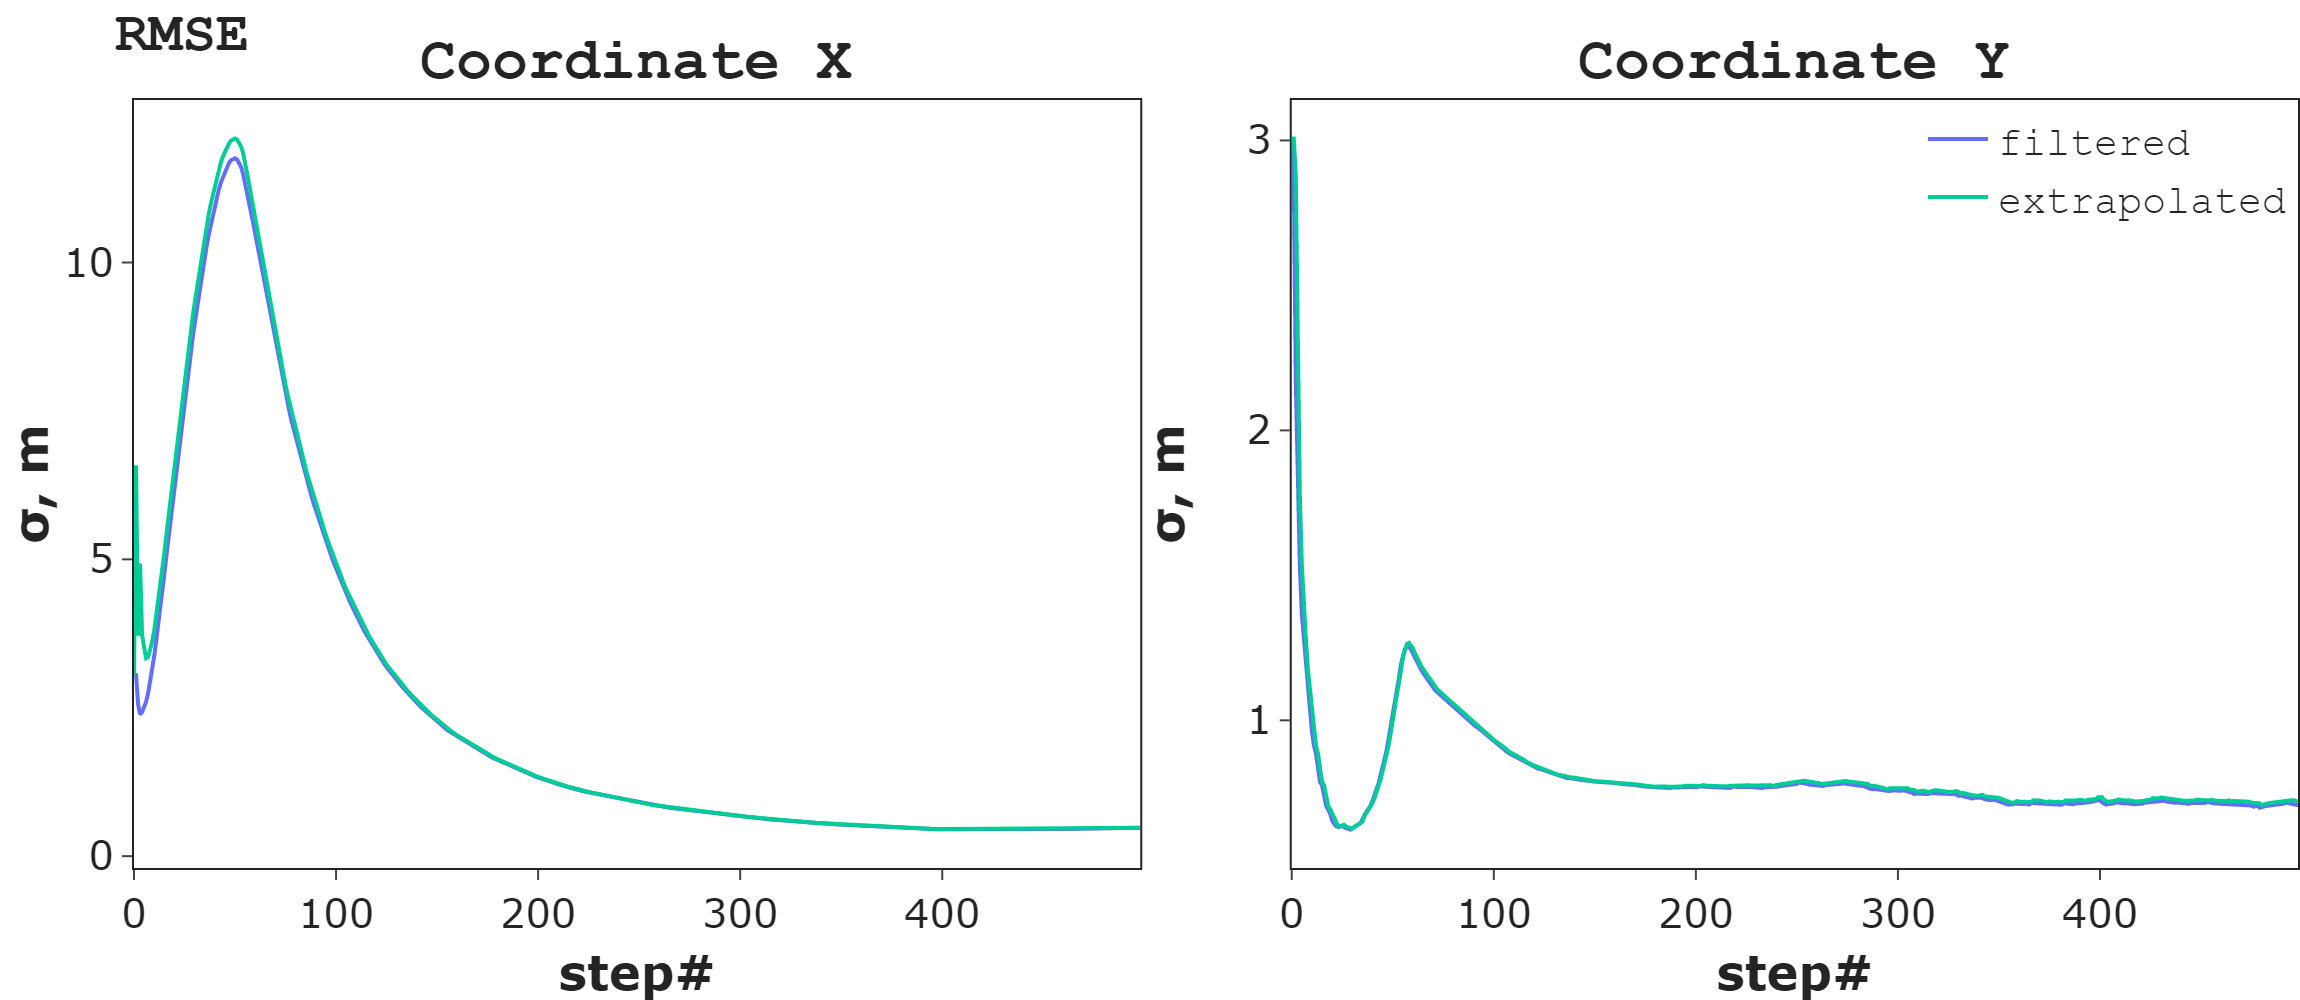

In [18]:
Image("RMSE_ext.png")

### #7 Comparison the estimation accuracy in case of assimilating GPS data only and fusion of both GPS data and odometry data

In [19]:
fig = go.Figure()
colors = px.colors.qualitative.Plotly
x = np.arange(sample_size)
fig.add_trace(go.Scatter(x = x, y = RMSE_true_filtered_ext[0, :sample_size-1] / RMSE_true_filtered[0, :sample_size-1], line_color = colors[0], name="True Trajectory"))


fig.update_layout(title='Estimation accuracy: RMSE_GPS_odometry_data / RMSE_GPS_data', xaxis_title='<b>step #</b>',yaxis_title = "")
fig.show()

fig.write_image("Estimation accuracy.png", format = 'png', width = 1150, height = 500, scale = 2)

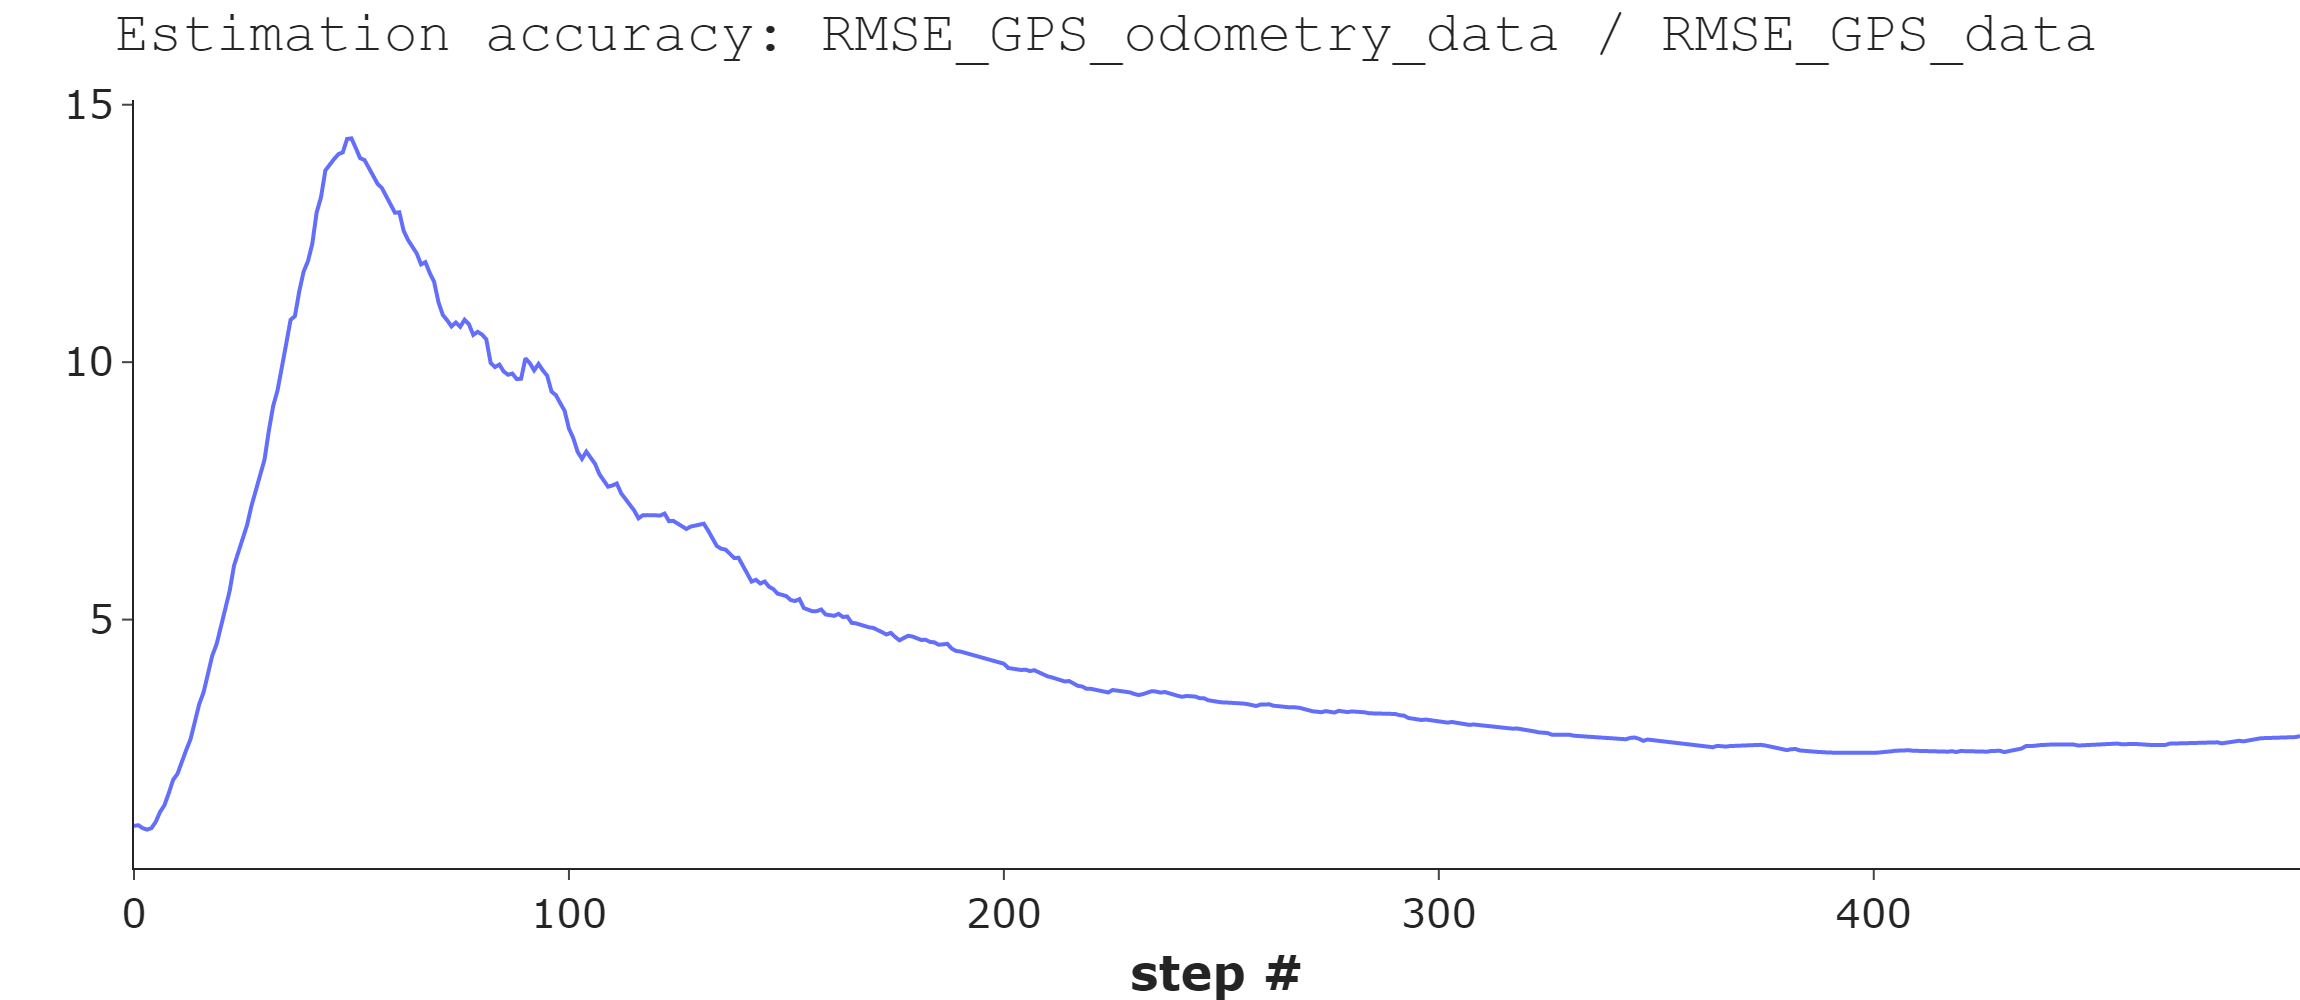

In [20]:
Image("Estimation accuracy.png")

Making fusion of both GPS data and odometry data, the estimation accuracy decreases

## Conclusions

Fusion of GPS data (absolute positioning) and odometry data (relative positioning) leads to the dramatic increase of errors in the beginning, and then the error decreasing but still higher twice than error of GPS data only. In this case related to the data fusion, there is need to make more than 300 steps in order the accuracy will increase and Kalman filter will be stabilized. 